In [122]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections
from maze_generator.maze_generator import generate_maze

Generate the maze

In [123]:
x_dim = 10
y_dim = 10
# fc_nn, conv_nn, conv_nn_2, conv_nn_3
model_type = 'fc_nn'
# generate_maze(x_dim, y_dim)

**Introduce experience replay.**

In [124]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

**Networks definition.**

In [125]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, classification = False, additional_out=False):        
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        return out

In [126]:
class conv_nn(nn.Module):
    
    channels = [8, 16, 32]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(nn.Linear(size_out_conv, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, n_act))


    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x),-1)
        out_lin = self.linear(out_conv)
        return out_lin
        
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1,self.in_channels, x, y))
        return int(np.prod(out_conv.size()))

In [127]:
class conv_nn_2(nn.Module):
    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    dropout_prob = 0.3
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(
            nn.Conv2d(self.in_channels, self.channels[0], kernel_size=self.kernels[0], stride=self.strides[0], padding=1),
            nn.BatchNorm2d(self.channels[0]),
            nn.ReLU(),
            nn.Conv2d(self.channels[0], self.channels[1], kernel_size=self.kernels[1], stride=self.strides[1], padding=1),
            nn.BatchNorm2d(self.channels[1]),
            nn.ReLU(),
            nn.Conv2d(self.channels[1], self.channels[2], kernel_size=self.kernels[2], stride=self.strides[2], padding=1),
            nn.BatchNorm2d(self.channels[2]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_prob)
        )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(
            nn.Linear(size_out_conv, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_act)
        )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x), -1)
        out_lin = self.linear(out_conv)
        return out_lin
        
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1, self.in_channels, x, y))
        return int(np.prod(out_conv.size()))


In [128]:
class conv_nn_3(nn.Module):
    channels = [32, 64, 128]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    dropout_prob = 0.3
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(
            nn.Conv2d(self.in_channels, self.channels[0], kernel_size=self.kernels[0], stride=self.strides[0], padding=1),
            nn.BatchNorm2d(self.channels[0]),
            nn.ReLU(),
            nn.Conv2d(self.channels[0], self.channels[1], kernel_size=self.kernels[1], stride=self.strides[1], padding=1),
            nn.BatchNorm2d(self.channels[1]),
            nn.ReLU(),
            nn.Conv2d(self.channels[1], self.channels[2], kernel_size=self.kernels[2], stride=self.strides[2], padding=1),
            nn.BatchNorm2d(self.channels[2]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_prob)
        )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(
            nn.Linear(size_out_conv, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_act)
        )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x), -1)
        out_lin = self.linear(out_conv)
        return out_lin
        
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1, self.in_channels, x, y))
        return int(np.prod(out_conv.size()))


In [129]:
def Qloss(batch, net, gamma=0.99, device="cuda"):
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)
    state_action_values = net(states.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    
    next_state_values = net(next_states.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]
    
    next_state_values = next_state_values.detach()
    expected_state_action_values = next_state_values * gamma + rewards
    
    return nn.MSELoss()(state_action_values, expected_state_action_values)

**Import the maze and define the environment.**

Reaching the Goal = +1 reward

Each Move = -0.05 reward (to encourage efficiency)

Revisiting a Cell = -0.2 reward (to discourage loops)

Hitting a Wall or Boundary = -1 reward (to prevent invalid moves)


In [130]:
from environment import MazeEnvironment

maze = np.load('maze_generator/maze.npy')

initial_position = [0,0]
goal = [len(maze)-1, len(maze)-1]

maze_env = MazeEnvironment(maze, initial_position, goal)

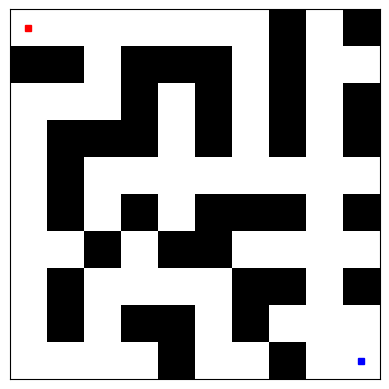

In [131]:
maze_env.draw('maze_20.pdf')

**Define the agent and the buffer for experience replay.**

In [132]:
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

In [133]:
from agent import Agent
agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
             )

In [134]:
agent.env

** Define the network.**

In [135]:
if model_type == 'fc_nn':
    net = fc_nn(maze.size, maze.size, maze.size, 4)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
elif model_type == 'conv_nn':
    net = conv_nn(x_dim, y_dim, 4)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
elif model_type == 'conv_nn_2':
    net = conv_nn_2(x_dim, y_dim, 4)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
elif model_type == 'conv_nn_3':
    net = conv_nn_3(x_dim, y_dim, 4)
    optimizer = optim.Adam(net.parameters(), lr=1e-4) 
else:
    raise ValueError(f"Unknown Model Type {model_type}")

In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 24
gamma = 0.9

net.to(device)

fc_nn(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=4, bias=True)
  (act): ReLU()
)

**Define the epsilon profile and plot the resetting probability.**

In [137]:
# Smaller cutoff leads to faster decay
num_epochs = 500
cutoff = 280

min_cutoff = max(1, int(num_epochs/100))  # Minimum cutoff to avoid division by zero
max_cutoff = num_epochs - 1  # Maximum cutoff to stay within array bounds
print(f"Valid cutoff range: {min_cutoff} to {max_cutoff}")

# Calculate index safely
index = min(int(num_epochs/cutoff) * 100, num_epochs-1)  # This ensures index is within bounds
print(f"Using index: {index}")

Valid cutoff range: 5 to 499
Using index: 100


[1.         0.99643494 0.99288259 0.98934291 0.98581584 0.98230135
 0.97879939 0.97530991 0.97183288 0.96836823 0.96491594 0.96147596
 0.95804824 0.95463275 0.95122942 0.94783824 0.94445914 0.94109208
 0.93773704 0.93439395 0.93106278 0.92774349 0.92443603 0.92114036
 0.91785644 0.91458423 0.91132368 0.90807476 0.90483742 0.90161162
 0.89839732 0.89519448 0.89200306 0.88882302 0.88565431 0.8824969
 0.87935075 0.87621581 0.87309205 0.86997943 0.8668779  0.86378743
 0.86070798 0.8576395  0.85458197 0.85153533 0.84849956 0.84547461
 0.84246044 0.83945702 0.83646431 0.83348226 0.83051085 0.82755003
 0.82459977 0.82166002 0.81873075 0.81581193 0.81290351 0.81000546
 0.80711775 0.80424032 0.80137316 0.79851622 0.79566946 0.79283285
 0.79000636 0.78718994 0.78438356 0.78158719 0.77880078 0.77602431
 0.77325774 0.77050103 0.76775415 0.76501706 0.76228973 0.75957212
 0.7568642  0.75416594 0.75147729 0.74879823 0.74612872 0.74346873
 0.74081822 0.73817716 0.73554552 0.73292325 0.73031034 0.72770

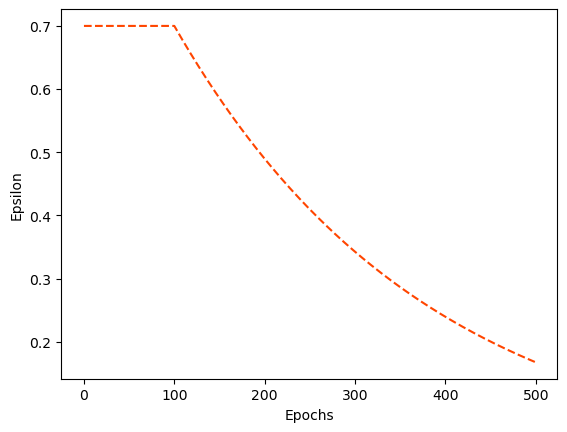

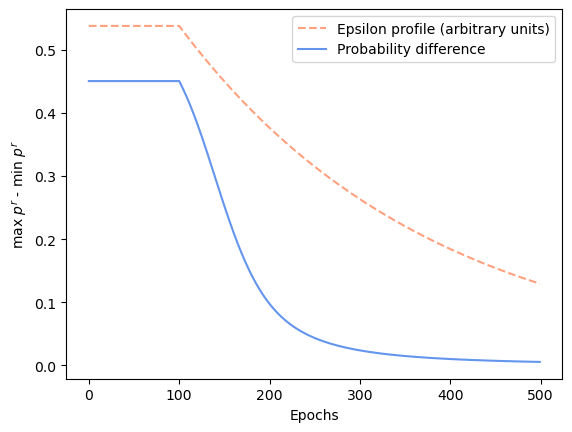

In [138]:
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
print(epsilon)
epsilon[epsilon > epsilon[index]] = epsilon[index]
# epsilon[epsilon > epsilon[int(num_epochs/cutoff) * 100 - 1]] = epsilon[int(num_epochs/cutoff) * 100 - 1]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

**Training the network.**

In [139]:
loss_log = []
best_loss = 1e5

running_loss = 0

moves_per_epoch = []
reward_per_epoch = []
for epoch in range(num_epochs):
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    agent.isgameon = True
    _ = agent.env.reset(eps)

    acc_reward = 0
    while agent.isgameon:
        acc_reward = agent.total_reward

        agent.make_a_move(net, eps)
        counter += 1
        
        if len(agent.buffer) < buffer_start_size:
            continue
            
        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device = device)
        states, actions, next_states, rewards, _ = batch
        loss_t = Qloss(batch, net, gamma = gamma, device = device)
        loss_t.backward()
        optimizer.step()
        
        loss += loss_t.item()

    print(f"Reward Gained: {acc_reward} (epsilon: {eps})")
    reward_per_epoch.append(acc_reward)

    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'
    
    if epoch%1000 == 0:
        agent.plot_policy_map(net, 'sol_epoch_'+str(epoch)+'.pdf', [0.35,-0.3])
    
    loss_log.append(loss)
    
    if (epoch > 2000):
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(net.state_dict(), "best.torch")
            estop = epoch
            
    moves_per_epoch.append(counter)
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if (epoch > 2000):
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
    clear_output(wait = True)
    
print(f"Model saved as 'best.torch'")

Model saved as 'best.torch'


Evaluating model from each blank spot in the maze...
Found 62 blank spots in the maze



===== Evaluation Results =====
Total blank spots evaluated: 62
Successful runs (reached goal): 62
Win rate: 100.00%
Average reward: -3.0331
Average number of moves: 15.92
Average loss of the last 50 epochs: 0.00829


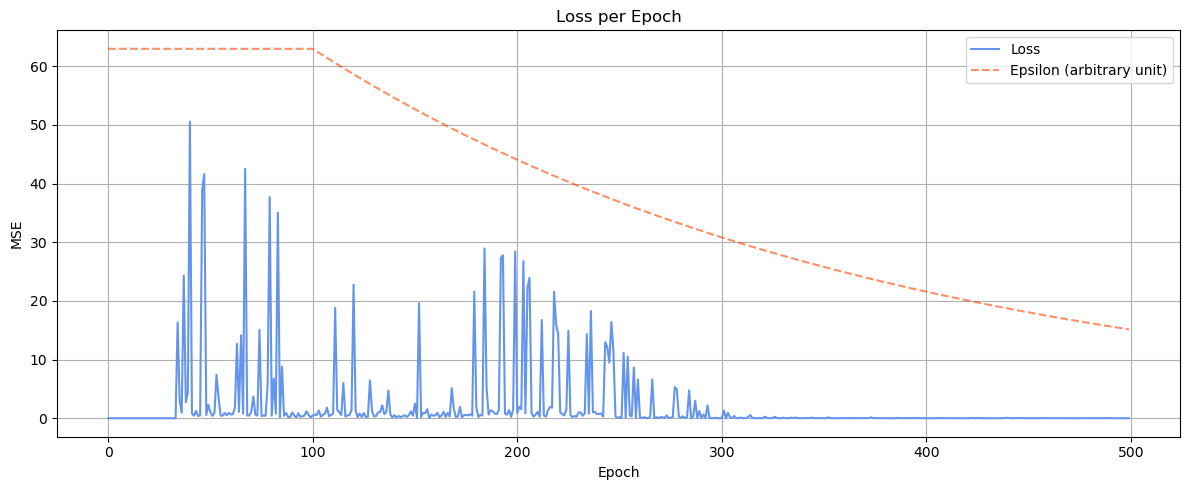

In [140]:
# Evaluate the model from each blank spot in the maze
print("Evaluating model from each blank spot in the maze...")

# Find all blank spots in the maze (cells with value 0)
maze = agent.env.maze
blank_spots = np.asarray(np.where(maze == 0)).T.tolist()

print(f"Found {len(blank_spots)} blank spots in the maze")

# Statistics to track
total_rewards = []
total_moves = []
successful_runs = 0

# Set the model to evaluation mode
net.eval()
agent.use_softmax = False

# Run simulation from each blank spot
for spot in blank_spots:
    agent.isgameon = True
    _ = agent.env.reset(0)  # Reset with epsilon=0 for greedy policy
    
    # Set the starting position to the current blank spot
    agent.env.current_position = np.array(spot)
    
    # Reset agent's total reward for this run
    agent.total_reward = 0
    
    # Run the simulation
    moves = 0
    while agent.isgameon and moves < 100:  # Adding a move limit to prevent infinite loops
        agent.make_a_move(net, 0)  # Use greedy policy (epsilon=0)
        moves += 1
        
        # Check if we've reached the goal
        if (agent.env.current_position == agent.env.goal).all():
            successful_runs += 1
            break
    
    # Record statistics
    total_rewards.append(agent.total_reward)
    total_moves.append(moves)

# Calculate and display results
avg_reward = sum(total_rewards) / len(total_rewards) if total_rewards else 0
avg_moves = sum(total_moves) / len(total_moves) if total_moves else 0
win_rate = successful_runs / len(blank_spots) * 100 if blank_spots else 0

print("\n===== Evaluation Results =====")
print(f"Total blank spots evaluated: {len(blank_spots)}")
print(f"Successful runs (reached goal): {successful_runs}")
print(f"Win rate: {win_rate:.2f}%")
print(f"Average reward: {avg_reward:.4f}")
print(f"Average number of moves: {avg_moves:.2f}")

# Calculate and display average loss from the last 50 epochs
if len(loss_log) >= 50:
    avg_loss_last_50 = sum(loss_log[-50:]) / 50
    print(f"Average loss of the last 50 epochs: {avg_loss_last_50:.5f}")
else:
    print(f"Average loss of all epochs: {sum(loss_log) / len(loss_log):.5f} (less than 50 epochs available)")

fig, ax = plt.subplots(figsize=(12, 5))

# Loss per epoch with Epsilon
ax.plot(loss_log, label='Loss', color='cornflowerblue')
ax.plot(epsilon * 90, alpha=0.6, ls='--', label='Epsilon (arbitrary unit)', color='orangered')
ax.set_title('Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()
ax.grid(True)

# Save and show plot
plt.tight_layout()
plt.savefig(f'plots/{model_type}_loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()


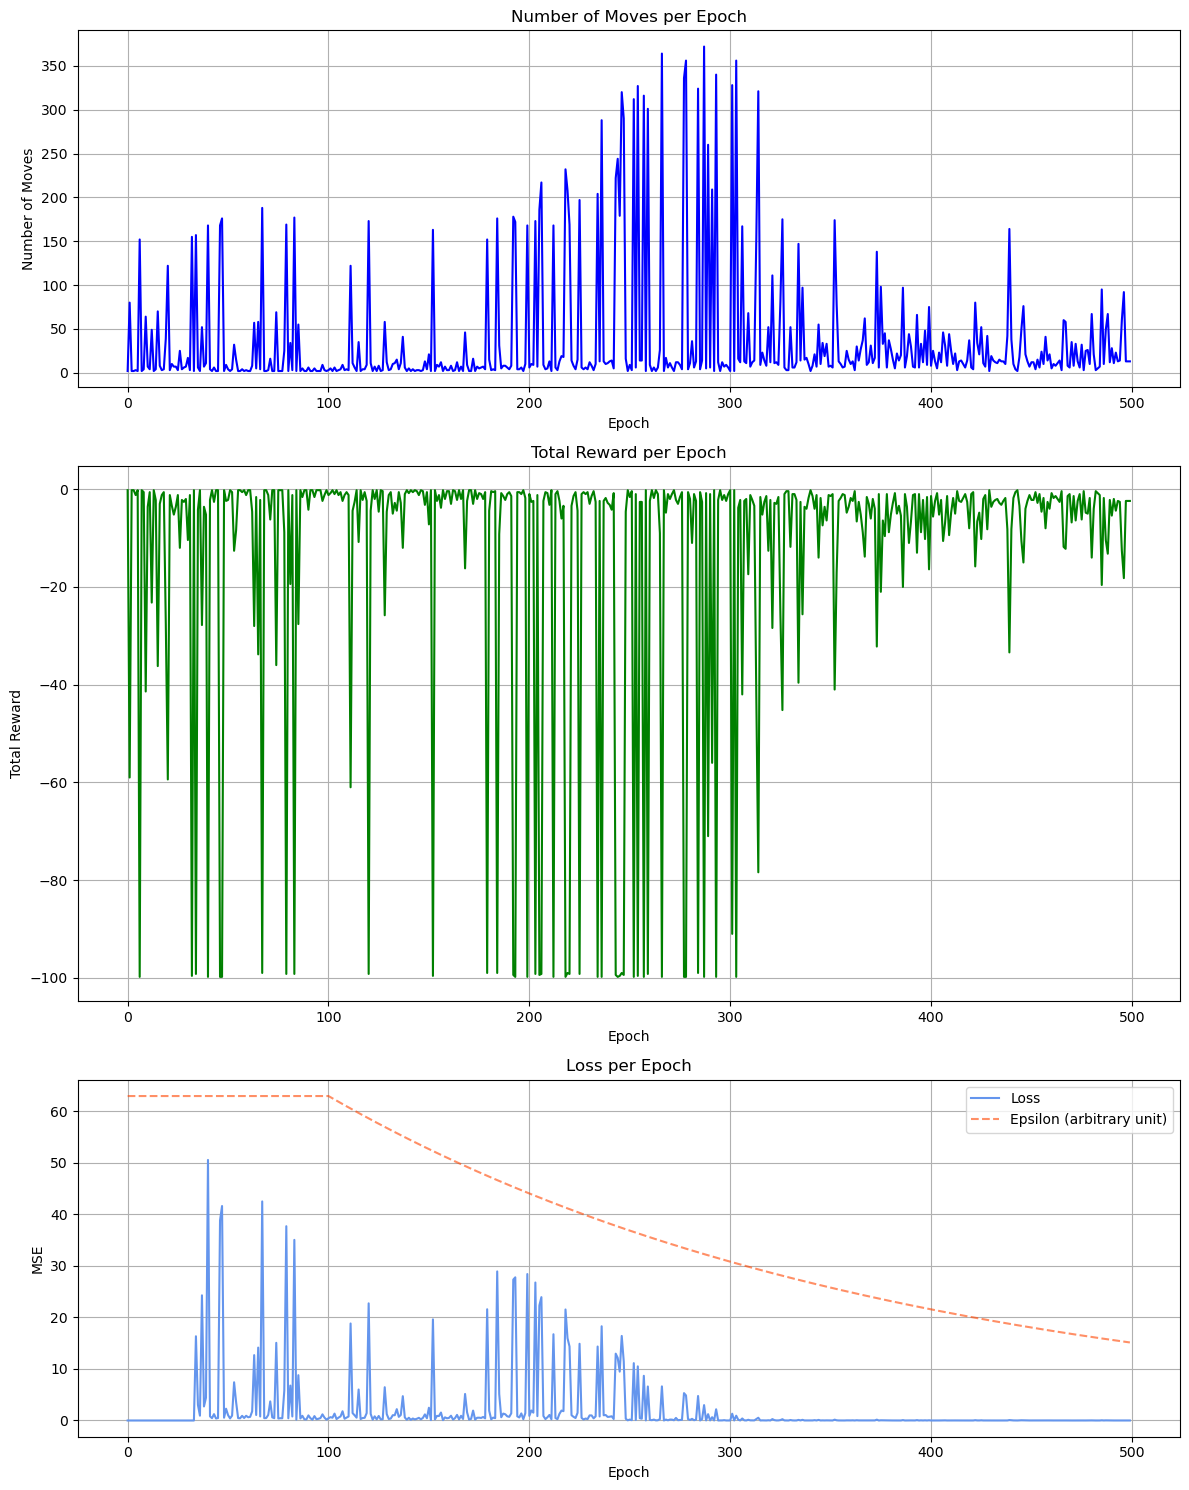

In [141]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), gridspec_kw={'height_ratios': [2, 3, 2]})

# Number of moves per epoch
axes[0].plot(moves_per_epoch, color='blue')
axes[0].set_title('Number of Moves per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Number of Moves')
axes[0].grid(True)

# Reward per epoch
axes[1].plot(reward_per_epoch, color='green')
axes[1].set_title('Total Reward per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Total Reward')
axes[1].grid(True)

# Loss per epoch with Epsilon
axes[2].plot(loss_log, label='Loss', color='cornflowerblue')
axes[2].plot(epsilon * 90, alpha=0.6, ls='--', label='Epsilon (arbitrary unit)', color='orangered')
axes[2].set_title('Loss per Epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('MSE')
axes[2].legend()
axes[2].grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'plots/{model_type}_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [142]:
torch.save(net.state_dict(), "net.torch")

Calculate average reward

In [143]:
agent.env

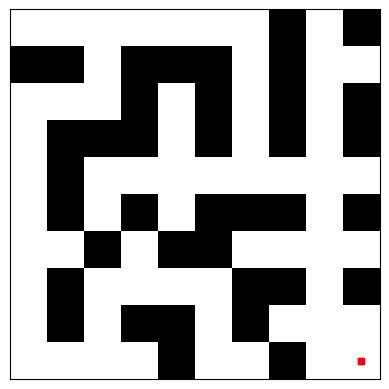

In [144]:
num_simulations = 10
for i in range(num_simulations):
    net.eval()
    agent.isgameon = True
    agent.use_softmax = False
    _ = agent.env.reset(0)
    while agent.isgameon:
        agent.make_a_move(net, 0)
        agent.env.draw('')
        clear_output(wait = True)

**Show the maze solution and the policy learnt.**

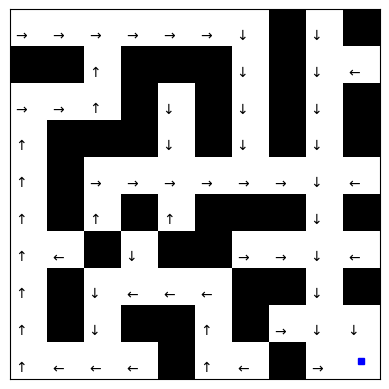

In [145]:
agent.plot_policy_map(net, 'solution.pdf', [0.35,-0.3])

In [146]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load('net.torch'))

<All keys matched successfully>

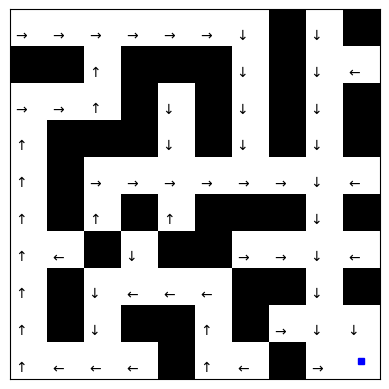

In [147]:
agent.plot_policy_map(best_net, 'solution_best.pdf', [0.35,-0.3])